# Шоколад (Oпределения рейтинга шоколада!)

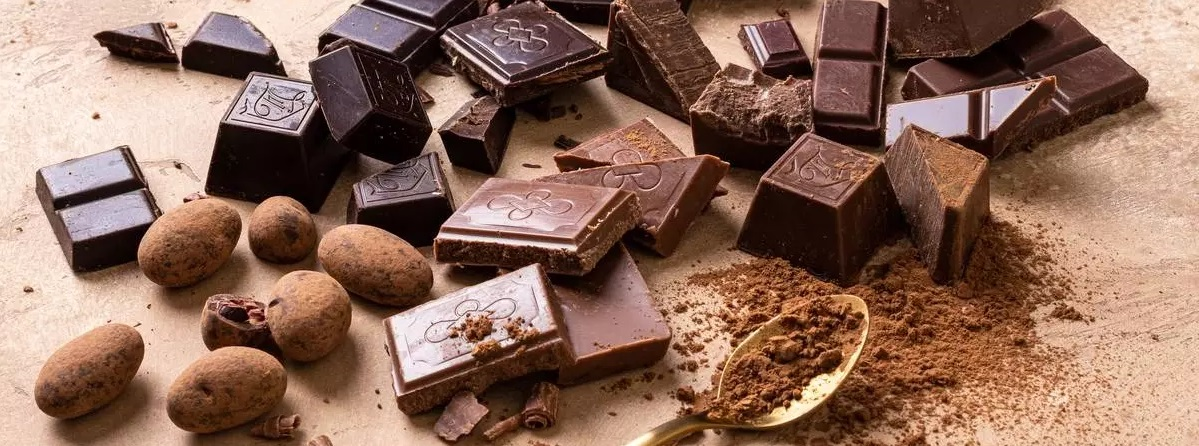

## Импорт библиотек, загрузка данных

In [ ]:
!pip install category_encoders -q

In [ ]:
!pip install catboost -q

In [66]:
import pandas as pd
import numpy as np
from urllib.parse import urlencode


import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

In [67]:
TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"

In [68]:
train_df = pd.read_csv(TRAIN)
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [69]:
test_df = pd.read_csv(TEST)
test_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Ohiyo,"San Juan Estate, Gran Couva",1594,2015,70%,U.S.A.,Trinitario,Trinidad
1,Blanxart,Organic Dark,322,2009,72%,Spain,,
2,Brazen,Maya Mountain,1518,2015,80%,U.S.A.,Trinitario,Belize
3,Patric,Madagascar,439,2009,67%,U.S.A.,Trinitario,Madagascar
4,Potomac,"Upala, Batch 12",607,2010,82%,U.S.A.,Matina,Costa Rica


## Обзор данных, подготовка к обучению

## Описание данных

- <b>Company</b> - компания производитель

- <b>Specific Bean Origin</b> - географический регион происхождения

- <b>REF</b> - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)

- <b>Review</b> - дата публикации отзыва

- <b>Cocoa Percent</b> - процентное содержание какао

- <b>Company Location</b> - страна производитель

- <b>Rating</b> - экспертный рейтинг

- <b>Bean Type</b> - используемый сорт какао-бобов, если таковой имеется

- <b>Broad Bean Origin</b> - географический регион происхождения какао-бобов


Работа с пропусками с пропусками

In [70]:
train_df = train_df.dropna()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1253 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1253 non-null   object 
 1   Specific Bean Origin  1253 non-null   object 
 2   REF                   1253 non-null   int64  
 3   Review                1253 non-null   int64  
 4   Cocoa Percent         1253 non-null   object 
 5   Company Location      1253 non-null   object 
 6   Rating                1253 non-null   float64
 7   Bean Type             1253 non-null   object 
 8   Broad Bean Origin     1253 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 97.9+ KB


In [71]:
#посмотрим статистику числовых значений
train_df.describe()

,REF,Review,Rating
count,1253.000000,1253.000000,1253.000000
mean,1045.483639,2012.383879,3.176377
std,551.624106,2.924551,0.478383
min,5.000000,2006.000000,1.000000
25%,593.000000,2010.000000,2.750000
50%,1081.000000,2013.000000,3.250000
75%,1514.000000,2015.000000,3.500000
max,1952.000000,2017.000000,5.000000


In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

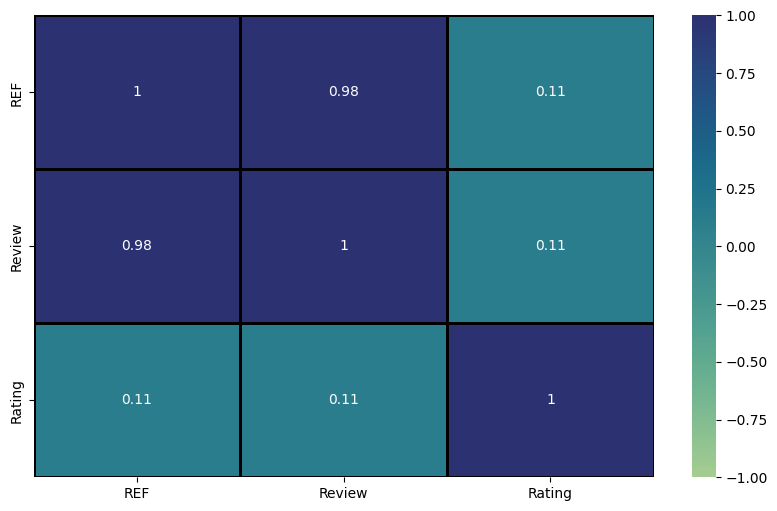

In [73]:
# изучим корреляция числовых признаков
fig = plt.figure(figsize = (10,6))
sns.heatmap(train_df.corr(numeric_only = True),
            cmap = "crest",
            annot = True,
            linewidths=1, linecolor='black',
            vmax = 1, vmin = -1)

In [74]:
# имеем сильную зависимость между REF и Review. Видно лопали шоколад, вносили данные а потоом сразу отзывы писать. Удалим Review.
train_df = train_df.drop(['Review'],axis = 1)

In [75]:
test_df = test_df.drop(['Review'],axis = 1)

In [76]:
#посмотрим статистику категориальных признаков
train_df.describe(include='object')

,Company,Specific Bean Origin,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
count,1253,1253,1253,1253,1253,1253
unique,376,761,40,58,38,83
top,Soma,Madagascar,70%,U.S.A.,,Venezuela
freq,34,38,460,520,628,144


In [77]:
train_df.isna().sum()

,0
Company,0
Specific Bean Origin,0
REF,0
Cocoa Percent,0
Company Location,0
Rating,0
Bean Type,0
Broad Bean Origin,0


In [78]:
test_df.isna().sum()

,0
Company,0
Specific Bean Origin,0
REF,0
Cocoa Percent,0
Company Location,0
Bean Type,0
Broad Bean Origin,0


Выделяем матрицу объект-признак и вектор с целевой переменной

In [79]:
#разбиение данных
y = train_df['Rating']
X = train_df.drop('Rating',axis = 1)
X.head()

,Company,Specific Bean Origin,REF,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,72%,U.K.,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,72%,Switzerland,,Venezuela
2,Dark Forest,Tanzania,1554,70%,U.S.A.,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,72%,U.S.A.,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,75%,France,Criollo,Indonesia


In [80]:
Xtest = test_df.copy()
Xtest.head()

,Company,Specific Bean Origin,REF,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Ohiyo,"San Juan Estate, Gran Couva",1594,70%,U.S.A.,Trinitario,Trinidad
1,Blanxart,Organic Dark,322,72%,Spain,,
2,Brazen,Maya Mountain,1518,80%,U.S.A.,Trinitario,Belize
3,Patric,Madagascar,439,67%,U.S.A.,Trinitario,Madagascar
4,Potomac,"Upala, Batch 12",607,82%,U.S.A.,Matina,Costa Rica


In [82]:
#разбиение данных
ytrain = train_df['Rating']
Xtrain =train_df.drop('Rating',axis = 1)

In [83]:
#закодируем данные
te = TargetEncoder()
te.fit(Xtrain, ytrain)

Xtrain = te.transform(Xtrain)
Xtrain.head()

,Company,Specific Bean Origin,REF,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,3.215090,3.157248,457,3.187984,3.054604,3.257923,3.236111
1,3.222739,3.218483,508,3.187984,3.278226,3.128981,3.236111
2,3.178245,3.128316,1554,3.257609,3.144231,3.128981,3.194636
3,3.256879,3.153429,1125,3.187984,3.144231,3.257923,3.194707
4,3.287439,3.218483,32,3.170181,3.260770,3.185094,3.229449


In [84]:
# Нормализуем данные
scaler = MinMaxScaler()
scaler.fit(Xtrain)
X = pd.DataFrame(scaler.transform(Xtrain), columns = Xtrain.columns)
Xtrain.head()

,Company,Specific Bean Origin,REF,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,3.215090,3.157248,457,3.187984,3.054604,3.257923,3.236111
1,3.222739,3.218483,508,3.187984,3.278226,3.128981,3.236111
2,3.178245,3.128316,1554,3.257609,3.144231,3.128981,3.194636
3,3.256879,3.153429,1125,3.187984,3.144231,3.257923,3.194707
4,3.287439,3.218483,32,3.170181,3.260770,3.185094,3.229449


Text(0.5, 1.0, 'Матрица корреляций')

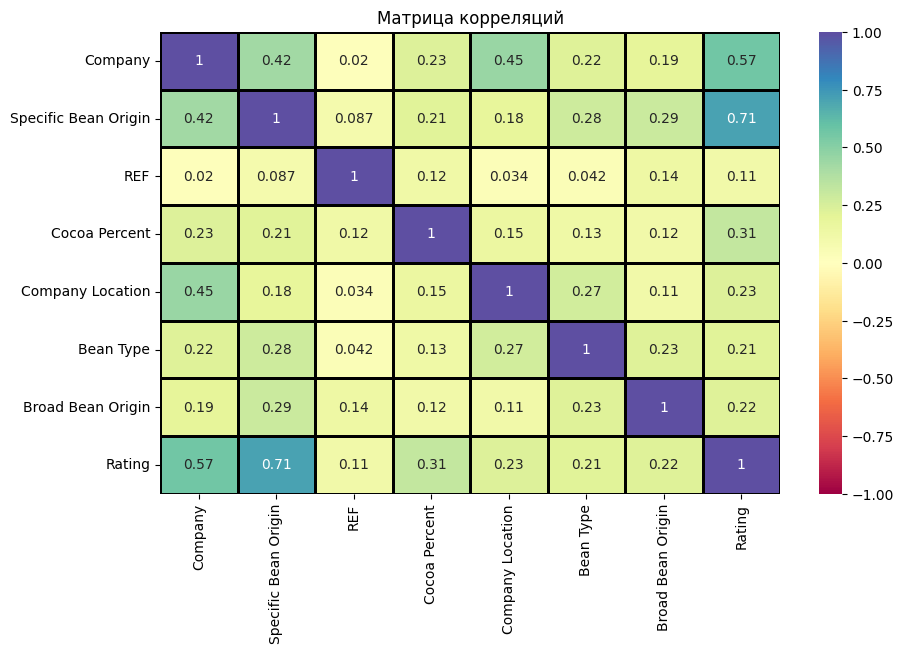

In [85]:
#построим матрицу корреляций всех признаков
fig = plt.figure(figsize = (10,6))
sns.heatmap(pd.concat([Xtrain,ytrain], axis = 1).corr(),
            cmap ="Spectral",
            annot = True,
            linewidths=1, linecolor='black',
            vmax = 1, vmin = -1)
plt.title("Матрица корреляций")

In [ ]:
#specific bean origin корелирует с рейтингом. Кто-то наверное любит швейцарский шоколад.
# а мы строим паплайн и ищем модельки...

In [86]:
df = pd.read_csv(TRAIN)
df = df.dropna()

y = df['Rating']
df = df.drop('Rating', axis = 1)

X = df.copy()
X = X.drop("Review", axis = 1)

pipe = Pipeline([

        ('encoder_', TargetEncoder()),
        ('scaler_',MinMaxScaler()),
        ('features',PolynomialFeatures())

])

pipe.fit(X, y)
X = pd.DataFrame(pipe.transform(X))
X.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,1.0,0.514719,0.605406,0.232152,0.795940,0.256864,0.798663,0.854029,0.264936,0.311614,...,0.633520,0.204449,0.635687,0.679755,0.065979,0.205148,0.219370,0.637862,0.682081,0.729365
1,1.0,0.526951,0.745812,0.258346,0.795940,0.855481,0.535429,0.854029,0.277677,0.393006,...,0.633520,0.680911,0.426169,0.679755,0.731847,0.458049,0.730605,0.286684,0.457272,0.729365
2,1.0,0.455800,0.539069,0.795583,0.947694,0.496788,0.535429,0.727289,0.207753,0.245708,...,0.898125,0.470803,0.507423,0.689248,0.246798,0.265994,0.361308,0.286684,0.389412,0.528950
3,1.0,0.581544,0.596649,0.575244,0.795940,0.496788,0.798663,0.727507,0.338194,0.346978,...,0.633520,0.395413,0.635687,0.579051,0.246798,0.396766,0.361416,0.637862,0.581032,0.529266
4,1.0,0.630413,0.745812,0.013867,0.757135,0.808754,0.649984,0.833673,0.397420,0.470169,...,0.573253,0.612336,0.492125,0.631202,0.654083,0.525677,0.674236,0.422479,0.541874,0.695010


In [87]:
#
test_df = pd.DataFrame(pipe.transform(test_df))
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,1.0,0.452812,0.734371,0.816127,0.947694,0.496788,0.798663,0.629006,0.205039,0.332532,...,0.898125,0.470803,0.756888,0.596105,0.246798,0.396766,0.312482,0.637862,0.502363,0.395648
1,1.0,0.520144,0.649267,0.162815,0.795940,0.611575,0.535429,0.000000,0.270550,0.337712,...,0.633520,0.486777,0.426169,0.000000,0.374024,0.327455,0.000000,0.286684,0.000000,0.000000
2,1.0,0.439011,0.629478,0.777093,0.445559,0.496788,0.798663,0.798732,0.192731,0.276348,...,0.198523,0.221348,0.355851,0.355882,0.246798,0.396766,0.396800,0.637862,0.637917,0.637973
3,1.0,0.656252,0.910636,0.222907,0.971712,0.496788,0.798663,0.903831,0.430667,0.597607,...,0.944223,0.482734,0.776070,0.878263,0.246798,0.396766,0.449012,0.637862,0.721856,0.816910
4,1.0,0.497867,0.649267,0.309194,0.735922,0.496788,0.585339,0.475268,0.247871,0.323248,...,0.541582,0.365597,0.430764,0.349760,0.246798,0.290789,0.236107,0.342621,0.278193,0.225879


## Обучение модели

<Axes: xlabel='Rating', ylabel='Count'>

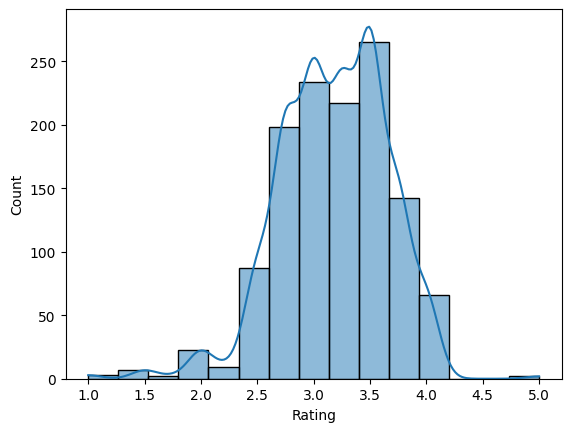

In [ ]:
#посмотрим на распределение целевой переменной
sns.histplot(y,bins = 15,kde=True)

In [ ]:
#Колокол в принципе виден если присмотретьтя, исходим из того  что распределение в целом нормальное

In [88]:
#категориальные колонки
cat_cols =  train_df.columns.get_indexer(train_df.select_dtypes(object).columns)
cat_cols

array([0, 1, 3, 4, 6, 7])

In [89]:
#лес Default params
rf = RandomForestRegressor()
print(f"R2: {cross_val_score(rf, X,y, cv = 3, scoring = 'r2').mean()}")
rf.fit(X,y)

R2: 0.679188033511586


RandomForestRegressor()

Устанавливаем катбуст и обучаем его с гиперпараметрами по умолчанию на всех данных

In [90]:
cb = CatBoostRegressor(verbose=0)

cross_val_score(cb, X, y, cv=3, scoring='r2').mean()

0.6685329880762593

In [91]:
# а что там у майкрасофт

lgbm = LGBMRegressor()

cross_val_score(lgbm, X, y, cv=3, scoring='r2').mean()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5409
[LightGBM] [Info] Number of data points in the train set: 835, number of used features: 35
[LightGBM] [Info] Start training from score 3.171257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tr

0.6482908763423985

In [92]:
# ну и еще один ....
xgb = XGBRegressor()

cross_val_score(xgb, X, y, cv=3, scoring='r2').mean()

0.6154503390620083

In [ ]:
# итак лес и катбуст идут ноздря в ноздрю, но...

In [94]:

!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.5 MB/s eta 0:00:00


In [95]:
import optuna

In [96]:
 #подбор параметров для RandomForest
def objective_rf(trial):
     param = {
         'max_depth': trial.suggest_int('max_depth', 2, 30),
         'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
         'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100),
         'max_features': trial.suggest_float('max_features', 0.1, 1.0)
     }

     estimator = RandomForestRegressor(**param,verbose=0,n_jobs = -1)

     score = cross_val_score(estimator,X,y, cv = 3, scoring = 'r2',verbose = 2).mean()
     return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_rf, n_trials=30)
trial_rf = study.best_trial

[I 2024-09-27 07:00:42,916] A new study created in memory with name: no-name-d514dac4-db14-4a6a-a02d-cead1123f72d


[CV] END .................................................... total time=   2.7s
[CV] END .................................................... total time=   2.0s


[I 2024-09-27 07:00:49,757] Trial 0 finished with value: 0.6045925649776445 and parameters: {'max_depth': 8, 'n_estimators': 472, 'min_samples_split': 100, 'min_samples_leaf': 57, 'max_features': 0.9854814629831249}. Best is trial 0 with value: 0.6045925649776445.


[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   2.6s


[I 2024-09-27 07:00:56,816] Trial 1 finished with value: 0.6449085232152193 and parameters: {'max_depth': 23, 'n_estimators': 542, 'min_samples_split': 49, 'min_samples_leaf': 22, 'max_features': 0.39338178027822457}. Best is trial 1 with value: 0.6449085232152193.


[CV] END .................................................... total time=   2.6s
[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   1.2s


[I 2024-09-27 07:01:00,277] Trial 2 finished with value: 0.614505473506722 and parameters: {'max_depth': 7, 'n_estimators': 369, 'min_samples_split': 44, 'min_samples_leaf': 53, 'max_features': 0.5109187399895236}. Best is trial 1 with value: 0.6449085232152193.


[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   1.7s


[I 2024-09-27 07:01:05,337] Trial 3 finished with value: 0.6067611621726142 and parameters: {'max_depth': 29, 'n_estimators': 423, 'min_samples_split': 57, 'min_samples_leaf': 59, 'max_features': 0.8489154124514493}. Best is trial 1 with value: 0.6449085232152193.


[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s


[I 2024-09-27 07:01:06,530] Trial 4 finished with value: 0.5809371946500024 and parameters: {'max_depth': 13, 'n_estimators': 117, 'min_samples_split': 25, 'min_samples_leaf': 96, 'max_features': 0.35070119408772815}. Best is trial 1 with value: 0.6449085232152193.


[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   3.5s
[CV] END .................................................... total time=   2.1s


[I 2024-09-27 07:01:14,243] Trial 5 finished with value: 0.6184672971052124 and parameters: {'max_depth': 24, 'n_estimators': 427, 'min_samples_split': 78, 'min_samples_leaf': 40, 'max_features': 0.9999163323891417}. Best is trial 1 with value: 0.6449085232152193.


[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   3.5s
[CV] END .................................................... total time=   4.7s


[I 2024-09-27 07:01:26,079] Trial 6 finished with value: 0.609637766962864 and parameters: {'max_depth': 13, 'n_estimators': 789, 'min_samples_split': 38, 'min_samples_leaf': 51, 'max_features': 0.9553574317771056}. Best is trial 1 with value: 0.6449085232152193.


[CV] END .................................................... total time=   3.6s
[CV] END .................................................... total time=   2.0s
[CV] END .................................................... total time=   2.0s


[I 2024-09-27 07:01:31,967] Trial 7 finished with value: 0.5906245081756282 and parameters: {'max_depth': 19, 'n_estimators': 602, 'min_samples_split': 22, 'min_samples_leaf': 79, 'max_features': 0.729513342011767}. Best is trial 1 with value: 0.6449085232152193.


[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.4s


[I 2024-09-27 07:01:33,623] Trial 8 finished with value: 0.6420042005217154 and parameters: {'max_depth': 24, 'n_estimators': 105, 'min_samples_split': 34, 'min_samples_leaf': 26, 'max_features': 0.5698594374507704}. Best is trial 1 with value: 0.6449085232152193.


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   2.9s
[CV] END .................................................... total time=   2.1s


[I 2024-09-27 07:01:39,950] Trial 9 finished with value: 0.6130730262203666 and parameters: {'max_depth': 4, 'n_estimators': 299, 'min_samples_split': 84, 'min_samples_leaf': 49, 'max_features': 0.809248667058026}. Best is trial 1 with value: 0.6449085232152193.


[CV] END .................................................... total time=   1.3s
[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.3s


[I 2024-09-27 07:01:46,814] Trial 10 finished with value: 0.6711917948406493 and parameters: {'max_depth': 19, 'n_estimators': 853, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 0.12980927676219006}. Best is trial 10 with value: 0.6711917948406493.


[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   4.6s
[CV] END .................................................... total time=   2.9s


[I 2024-09-27 07:01:57,259] Trial 11 finished with value: 0.6707740663394554 and parameters: {'max_depth': 20, 'n_estimators': 952, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 0.12488762132389075}. Best is trial 10 with value: 0.6711917948406493.


[CV] END .................................................... total time=   2.8s
[CV] END .................................................... total time=   3.4s
[CV] END .................................................... total time=   4.4s


[I 2024-09-27 07:02:07,910] Trial 12 finished with value: 0.6728671548443512 and parameters: {'max_depth': 18, 'n_estimators': 986, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.1333455450174318}. Best is trial 12 with value: 0.6728671548443512.


[CV] END .................................................... total time=   2.8s
[CV] END .................................................... total time=   2.9s
[CV] END .................................................... total time=   2.9s


[I 2024-09-27 07:02:18,498] Trial 13 finished with value: 0.6702793922181999 and parameters: {'max_depth': 15, 'n_estimators': 978, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.12585140580469395}. Best is trial 12 with value: 0.6728671548443512.


[CV] END .................................................... total time=   4.7s
[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.0s


[I 2024-09-27 07:02:24,602] Trial 14 finished with value: 0.6498345432494044 and parameters: {'max_depth': 18, 'n_estimators': 736, 'min_samples_split': 10, 'min_samples_leaf': 18, 'max_features': 0.24827149230231177}. Best is trial 12 with value: 0.6728671548443512.


[CV] END .................................................... total time=   2.0s
[CV] END .................................................... total time=   2.7s
[CV] END .................................................... total time=   4.4s


[I 2024-09-27 07:02:34,313] Trial 15 finished with value: 0.6607766702336495 and parameters: {'max_depth': 29, 'n_estimators': 838, 'min_samples_split': 19, 'min_samples_leaf': 13, 'max_features': 0.28436922705475626}. Best is trial 12 with value: 0.6728671548443512.


[CV] END .................................................... total time=   2.6s
[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.1s


[I 2024-09-27 07:02:40,668] Trial 16 finished with value: 0.6230622566598599 and parameters: {'max_depth': 10, 'n_estimators': 882, 'min_samples_split': 14, 'min_samples_leaf': 35, 'max_features': 0.2198727343551617}. Best is trial 12 with value: 0.6728671548443512.


[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   4.3s
[CV] END .................................................... total time=   2.6s


[I 2024-09-27 07:02:50,236] Trial 17 finished with value: 0.6542959952188027 and parameters: {'max_depth': 16, 'n_estimators': 672, 'min_samples_split': 59, 'min_samples_leaf': 11, 'max_features': 0.4859209481964133}. Best is trial 12 with value: 0.6728671548443512.


[CV] END .................................................... total time=   2.6s
[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   2.0s


[I 2024-09-27 07:02:56,950] Trial 18 finished with value: 0.5347268230464994 and parameters: {'max_depth': 22, 'n_estimators': 896, 'min_samples_split': 30, 'min_samples_leaf': 72, 'max_features': 0.10170426381212391}. Best is trial 12 with value: 0.6728671548443512.


[CV] END .................................................... total time=   2.7s
[CV] END .................................................... total time=   2.8s
[CV] END .................................................... total time=   2.3s


[I 2024-09-27 07:03:04,472] Trial 19 finished with value: 0.6352140721541683 and parameters: {'max_depth': 12, 'n_estimators': 712, 'min_samples_split': 11, 'min_samples_leaf': 30, 'max_features': 0.39834324838317925}. Best is trial 12 with value: 0.6728671548443512.


[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.7s
[CV] END .................................................... total time=   3.6s


[I 2024-09-27 07:03:13,779] Trial 20 finished with value: 0.6457110562260807 and parameters: {'max_depth': 27, 'n_estimators': 1000, 'min_samples_split': 66, 'min_samples_leaf': 9, 'max_features': 0.21164374162838262}. Best is trial 12 with value: 0.6728671548443512.


[CV] END .................................................... total time=   2.9s
[CV] END .................................................... total time=   2.8s
[CV] END .................................................... total time=   2.8s


[I 2024-09-27 07:03:22,454] Trial 21 finished with value: 0.6782895392050095 and parameters: {'max_depth': 20, 'n_estimators': 929, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 0.15869002606881064}. Best is trial 21 with value: 0.6782895392050095.


[CV] END .................................................... total time=   3.0s
[CV] END .................................................... total time=   3.9s
[CV] END .................................................... total time=   3.2s


[I 2024-09-27 07:03:32,920] Trial 22 finished with value: 0.679699749455108 and parameters: {'max_depth': 18, 'n_estimators': 818, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 0.1862431208811296}. Best is trial 22 with value: 0.679699749455108.


[CV] END .................................................... total time=   3.3s
[CV] END .................................................... total time=   2.6s
[CV] END .................................................... total time=   4.0s


[I 2024-09-27 07:03:42,063] Trial 23 finished with value: 0.65189486641259 and parameters: {'max_depth': 16, 'n_estimators': 786, 'min_samples_split': 17, 'min_samples_leaf': 19, 'max_features': 0.342924285640114}. Best is trial 22 with value: 0.679699749455108.


[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.4s


[I 2024-09-27 07:03:49,545] Trial 24 finished with value: 0.658454057760787 and parameters: {'max_depth': 26, 'n_estimators': 916, 'min_samples_split': 24, 'min_samples_leaf': 11, 'max_features': 0.18843610986215076}. Best is trial 22 with value: 0.679699749455108.


[CV] END .................................................... total time=   2.6s
[CV] END .................................................... total time=   2.7s
[CV] END .................................................... total time=   1.6s


[I 2024-09-27 07:03:55,435] Trial 25 finished with value: 0.6231700368462536 and parameters: {'max_depth': 20, 'n_estimators': 603, 'min_samples_split': 2, 'min_samples_leaf': 40, 'max_features': 0.29356077161207295}. Best is trial 22 with value: 0.679699749455108.


[CV] END .................................................... total time=   1.5s
[CV] END .................................................... total time=   2.0s
[CV] END .................................................... total time=   2.0s


[I 2024-09-27 07:04:01,546] Trial 26 finished with value: 0.648150892000768 and parameters: {'max_depth': 21, 'n_estimators': 801, 'min_samples_split': 11, 'min_samples_leaf': 16, 'max_features': 0.18616287528955838}. Best is trial 22 with value: 0.679699749455108.


[CV] END .................................................... total time=   2.0s
[CV] END .................................................... total time=   7.0s
[CV] END .................................................... total time=   5.2s


[I 2024-09-27 07:04:20,708] Trial 27 finished with value: 0.6779296054762236 and parameters: {'max_depth': 17, 'n_estimators': 931, 'min_samples_split': 29, 'min_samples_leaf': 5, 'max_features': 0.6077837003729865}. Best is trial 22 with value: 0.679699749455108.


[CV] END .................................................... total time=   6.9s
[CV] END .................................................... total time=   2.8s
[CV] END .................................................... total time=   2.8s


[I 2024-09-27 07:04:29,067] Trial 28 finished with value: 0.6431341022844612 and parameters: {'max_depth': 14, 'n_estimators': 686, 'min_samples_split': 28, 'min_samples_leaf': 25, 'max_features': 0.5997542423123094}. Best is trial 22 with value: 0.679699749455108.


[CV] END .................................................... total time=   2.8s
[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.3s


[I 2024-09-27 07:04:35,069] Trial 29 finished with value: 0.6702741402747544 and parameters: {'max_depth': 11, 'n_estimators': 261, 'min_samples_split': 41, 'min_samples_leaf': 7, 'max_features': 0.6568856466097515}. Best is trial 22 with value: 0.679699749455108.


[CV] END .................................................... total time=   1.4s


In [97]:
print("rf")
print(f"R2: {trial_rf.value}")
print(f"Best params: {trial_rf.params}")

rf
R2: 0.679699749455108
Best params: {'max_depth': 18, 'n_estimators': 818, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 0.1862431208811296}


In [98]:
model_rf = RandomForestRegressor(**{'max_depth': 18, 'n_estimators': 818, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 0.1862431208811296})

In [99]:
print(f"R2: {cross_val_score(model_rf, X,y, cv = 3, scoring = 'r2').mean()}")
model_rf.fit(X,y)

R2: 0.6801177420576576


RandomForestRegressor(max_depth=18, max_features=0.1862431208811296,
                      min_samples_leaf=3, n_estimators=818)

In [100]:
y_rf = model_rf.predict(test_df)

Сохраняем предсказание в файл в нужном формате

In [101]:
data = pd.DataFrame(np.arange(0, len(test_df)), columns = ['id'])
data['Rating'] = y_rf
data[['id','Rating']].to_csv("forests.csv", index=False)

In [102]:
#подбор параметров для catboost

def objective_catboost(trial):
     param = {

         "depth":trial.suggest_int("depth",2,10),
         'iterations':trial.suggest_int('iterations',100,1000),
         'l2_leaf_reg':trial.suggest_int('l2_leaf_reg',2,10),
         'learning_rate':trial.suggest_float('learning_rate', 0.001, 0.01),
         'random_strength': trial.suggest_int('random_strength', 0, 10)

     }

     estimator = CatBoostRegressor(**param,verbose=0)

     score = cross_val_score(estimator,X,y, cv = 3, scoring = 'r2',verbose = 2).mean()
     return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=30)
trial_catboost = study.best_trial

[I 2024-09-27 07:19:29,144] A new study created in memory with name: no-name-26dacba3-0772-4351-8d67-2819d635a170


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.5s


[I 2024-09-27 07:19:30,400] Trial 0 finished with value: 0.43761215447846014 and parameters: {'depth': 2, 'iterations': 191, 'l2_leaf_reg': 5, 'learning_rate': 0.005750484073419927, 'random_strength': 4}. Best is trial 0 with value: 0.43761215447846014.


[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   4.7s
[CV] END .................................................... total time=   3.4s


[I 2024-09-27 07:19:41,883] Trial 1 finished with value: 0.6142289013110138 and parameters: {'depth': 5, 'iterations': 858, 'l2_leaf_reg': 4, 'learning_rate': 0.0036181588152417944, 'random_strength': 7}. Best is trial 1 with value: 0.6142289013110138.


[CV] END .................................................... total time=   3.4s
[CV] END .................................................... total time= 1.3min
[CV] END .................................................... total time= 1.2min


[I 2024-09-27 07:23:23,261] Trial 2 finished with value: 0.6419717671799477 and parameters: {'depth': 10, 'iterations': 994, 'l2_leaf_reg': 4, 'learning_rate': 0.006778001337702955, 'random_strength': 4}. Best is trial 2 with value: 0.6419717671799477.


[CV] END .................................................... total time= 1.2min
[CV] END .................................................... total time=  22.7s
[CV] END .................................................... total time=  24.4s


[I 2024-09-27 07:24:34,794] Trial 3 finished with value: 0.6028452560842629 and parameters: {'depth': 10, 'iterations': 328, 'l2_leaf_reg': 5, 'learning_rate': 0.008645220151016798, 'random_strength': 2}. Best is trial 2 with value: 0.6419717671799477.


[CV] END .................................................... total time=  24.4s
[CV] END .................................................... total time=   7.9s
[CV] END .................................................... total time=   8.2s


[I 2024-09-27 07:24:59,820] Trial 4 finished with value: 0.644551041206817 and parameters: {'depth': 7, 'iterations': 649, 'l2_leaf_reg': 4, 'learning_rate': 0.008074998701328533, 'random_strength': 7}. Best is trial 4 with value: 0.644551041206817.


[CV] END .................................................... total time=   8.9s
[CV] END .................................................... total time=  31.5s
[CV] END .................................................... total time=  31.4s


[I 2024-09-27 07:26:35,577] Trial 5 finished with value: 0.6382240246038821 and parameters: {'depth': 9, 'iterations': 746, 'l2_leaf_reg': 8, 'learning_rate': 0.007957137056337861, 'random_strength': 4}. Best is trial 4 with value: 0.644551041206817.


[CV] END .................................................... total time=  32.9s
[CV] END .................................................... total time=   8.2s
[CV] END .................................................... total time=  10.0s


[I 2024-09-27 07:27:03,704] Trial 6 finished with value: 0.2982625121077489 and parameters: {'depth': 10, 'iterations': 127, 'l2_leaf_reg': 3, 'learning_rate': 0.004354772984793919, 'random_strength': 9}. Best is trial 4 with value: 0.644551041206817.


[CV] END .................................................... total time=   9.9s
[CV] END .................................................... total time=  53.2s
[CV] END .................................................... total time=  53.3s


[I 2024-09-27 07:29:42,633] Trial 7 finished with value: 0.6323867994471505 and parameters: {'depth': 10, 'iterations': 723, 'l2_leaf_reg': 8, 'learning_rate': 0.009997286188836878, 'random_strength': 9}. Best is trial 4 with value: 0.644551041206817.


[CV] END .................................................... total time=  52.4s
[CV] END .................................................... total time=   1.4s
[CV] END .................................................... total time=   0.7s


[I 2024-09-27 07:29:45,415] Trial 8 finished with value: 0.6157123840890201 and parameters: {'depth': 2, 'iterations': 593, 'l2_leaf_reg': 9, 'learning_rate': 0.008380738948779111, 'random_strength': 4}. Best is trial 4 with value: 0.644551041206817.


[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   6.0s
[CV] END .................................................... total time=   7.8s


[I 2024-09-27 07:30:05,798] Trial 9 finished with value: 0.6436457449024188 and parameters: {'depth': 6, 'iterations': 937, 'l2_leaf_reg': 2, 'learning_rate': 0.004667301313029595, 'random_strength': 7}. Best is trial 4 with value: 0.644551041206817.


[CV] END .................................................... total time=   6.5s
[CV] END .................................................... total time=   6.7s
[CV] END .................................................... total time=   4.9s


[I 2024-09-27 07:30:23,503] Trial 10 finished with value: 0.39120743599075336 and parameters: {'depth': 7, 'iterations': 435, 'l2_leaf_reg': 7, 'learning_rate': 0.0013435824784999101, 'random_strength': 0}. Best is trial 4 with value: 0.644551041206817.


[CV] END .................................................... total time=   6.1s
[CV] END .................................................... total time=   6.6s
[CV] END .................................................... total time=   8.2s


[I 2024-09-27 07:30:44,585] Trial 11 finished with value: 0.6228594885927968 and parameters: {'depth': 6, 'iterations': 977, 'l2_leaf_reg': 2, 'learning_rate': 0.0032531104884158963, 'random_strength': 8}. Best is trial 4 with value: 0.644551041206817.


[CV] END .................................................... total time=   6.3s
[CV] END .................................................... total time=   7.9s
[CV] END .................................................... total time=   6.3s


[I 2024-09-27 07:31:06,856] Trial 12 finished with value: 0.628446836291939 and parameters: {'depth': 7, 'iterations': 556, 'l2_leaf_reg': 2, 'learning_rate': 0.0057675609562694045, 'random_strength': 6}. Best is trial 4 with value: 0.644551041206817.


[CV] END .................................................... total time=   8.1s
[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   2.0s


[I 2024-09-27 07:31:12,752] Trial 13 finished with value: 0.6337235910375675 and parameters: {'depth': 4, 'iterations': 726, 'l2_leaf_reg': 3, 'learning_rate': 0.006882277079155636, 'random_strength': 10}. Best is trial 4 with value: 0.644551041206817.


[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=  21.1s
[CV] END .................................................... total time=  19.3s


[I 2024-09-27 07:32:14,144] Trial 14 finished with value: 0.5209508560675095 and parameters: {'depth': 8, 'iterations': 881, 'l2_leaf_reg': 6, 'learning_rate': 0.0018450679713337297, 'random_strength': 6}. Best is trial 4 with value: 0.644551041206817.


[CV] END .................................................... total time=  20.9s
[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   1.1s


[I 2024-09-27 07:32:17,374] Trial 15 finished with value: 0.5504733246805867 and parameters: {'depth': 4, 'iterations': 401, 'l2_leaf_reg': 3, 'learning_rate': 0.004653717183322739, 'random_strength': 7}. Best is trial 4 with value: 0.644551041206817.


[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   4.0s
[CV] END .................................................... total time=   5.9s


[I 2024-09-27 07:32:31,400] Trial 16 finished with value: 0.6590255545711607 and parameters: {'depth': 6, 'iterations': 624, 'l2_leaf_reg': 2, 'learning_rate': 0.009761995945830184, 'random_strength': 6}. Best is trial 16 with value: 0.6590255545711607.


[CV] END .................................................... total time=   4.1s
[CV] END .................................................... total time=  14.3s
[CV] END .................................................... total time=  14.4s


[I 2024-09-27 07:33:14,447] Trial 17 finished with value: 0.6604240074711919 and parameters: {'depth': 8, 'iterations': 635, 'l2_leaf_reg': 4, 'learning_rate': 0.009773132326088589, 'random_strength': 2}. Best is trial 17 with value: 0.6604240074711919.


[CV] END .................................................... total time=  14.3s
[CV] END .................................................... total time=  10.9s
[CV] END .................................................... total time=  11.0s


[I 2024-09-27 07:33:47,139] Trial 18 finished with value: 0.6502348020841945 and parameters: {'depth': 8, 'iterations': 462, 'l2_leaf_reg': 5, 'learning_rate': 0.009972439600997958, 'random_strength': 2}. Best is trial 17 with value: 0.6604240074711919.


[CV] END .................................................... total time=  10.8s
[CV] END .................................................... total time=   1.3s
[CV] END .................................................... total time=   1.2s


[I 2024-09-27 07:33:50,830] Trial 19 finished with value: 0.607052105608485 and parameters: {'depth': 5, 'iterations': 287, 'l2_leaf_reg': 10, 'learning_rate': 0.009178966324058936, 'random_strength': 2}. Best is trial 17 with value: 0.6604240074711919.


[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=  14.6s
[CV] END .................................................... total time=  14.5s


[I 2024-09-27 07:34:34,387] Trial 20 finished with value: 0.6694603667903527 and parameters: {'depth': 8, 'iterations': 642, 'l2_leaf_reg': 6, 'learning_rate': 0.007073753796275912, 'random_strength': 0}. Best is trial 20 with value: 0.6694603667903527.


[CV] END .................................................... total time=  14.5s
[CV] END .................................................... total time=  14.7s
[CV] END .................................................... total time=  14.7s


[I 2024-09-27 07:35:18,552] Trial 21 finished with value: 0.6700747706951474 and parameters: {'depth': 8, 'iterations': 655, 'l2_leaf_reg': 6, 'learning_rate': 0.007186429448829256, 'random_strength': 0}. Best is trial 21 with value: 0.6700747706951474.


[CV] END .................................................... total time=  14.7s
[CV] END .................................................... total time=  11.6s
[CV] END .................................................... total time=  11.6s


[I 2024-09-27 07:35:53,417] Trial 22 finished with value: 0.6600460782785368 and parameters: {'depth': 8, 'iterations': 497, 'l2_leaf_reg': 6, 'learning_rate': 0.006970241188999328, 'random_strength': 0}. Best is trial 21 with value: 0.6700747706951474.


[CV] END .................................................... total time=  11.6s
[CV] END .................................................... total time=  35.4s
[CV] END .................................................... total time=  34.0s


[I 2024-09-27 07:37:38,753] Trial 23 finished with value: 0.6532907786177063 and parameters: {'depth': 9, 'iterations': 816, 'l2_leaf_reg': 6, 'learning_rate': 0.007338854497407668, 'random_strength': 1}. Best is trial 21 with value: 0.6700747706951474.


[CV] END .................................................... total time=  35.9s
[CV] END .................................................... total time=  28.8s
[CV] END .................................................... total time=  28.4s


[I 2024-09-27 07:39:05,310] Trial 24 finished with value: 0.6358875221244187 and parameters: {'depth': 9, 'iterations': 674, 'l2_leaf_reg': 7, 'learning_rate': 0.006169489853347615, 'random_strength': 1}. Best is trial 21 with value: 0.6700747706951474.


[CV] END .................................................... total time=  29.3s
[CV] END .................................................... total time=  12.6s
[CV] END .................................................... total time=  12.6s


[I 2024-09-27 07:39:42,921] Trial 25 finished with value: 0.6522886464669028 and parameters: {'depth': 8, 'iterations': 535, 'l2_leaf_reg': 7, 'learning_rate': 0.008918317990335455, 'random_strength': 1}. Best is trial 21 with value: 0.6700747706951474.


[CV] END .................................................... total time=  12.4s
[CV] END .................................................... total time=  10.5s
[CV] END .................................................... total time=   9.1s


[I 2024-09-27 07:40:12,730] Trial 26 finished with value: 0.6803588756136879 and parameters: {'depth': 7, 'iterations': 798, 'l2_leaf_reg': 5, 'learning_rate': 0.007659380832731335, 'random_strength': 0}. Best is trial 26 with value: 0.6803588756136879.


[CV] END .................................................... total time=  10.2s
[CV] END .................................................... total time=  10.8s
[CV] END .................................................... total time=  10.7s


[I 2024-09-27 07:40:44,166] Trial 27 finished with value: 0.6805268650546901 and parameters: {'depth': 7, 'iterations': 824, 'l2_leaf_reg': 5, 'learning_rate': 0.007516256224834906, 'random_strength': 0}. Best is trial 27 with value: 0.6805268650546901.


[CV] END .................................................... total time=   9.9s
[CV] END .................................................... total time=   9.7s
[CV] END .................................................... total time=  10.7s


[I 2024-09-27 07:41:15,317] Trial 28 finished with value: 0.6585308600816847 and parameters: {'depth': 7, 'iterations': 811, 'l2_leaf_reg': 5, 'learning_rate': 0.007626717301658692, 'random_strength': 3}. Best is trial 27 with value: 0.6805268650546901.


[CV] END .................................................... total time=  10.7s
[CV] END .................................................... total time=   9.5s
[CV] END .................................................... total time=   9.4s


[I 2024-09-27 07:41:44,561] Trial 29 finished with value: 0.6767238755276074 and parameters: {'depth': 7, 'iterations': 783, 'l2_leaf_reg': 5, 'learning_rate': 0.006417729847436614, 'random_strength': 0}. Best is trial 27 with value: 0.6805268650546901.


[CV] END .................................................... total time=  10.3s


In [106]:
model_cb = CatBoostRegressor(**{'depth': 7, 'iterations': 824, 'l2_leaf_reg':5, 'learning_rate': 0.007516256224834906, 'random_strength': 0},verbose = 0)

In [107]:
print(f"R2: {cross_val_score(model_cb, X,y, cv = 3, scoring = 'r2').mean()}")
model_cb.fit(X,y)

R2: 0.6805268650546901


In [108]:
y_cat = model_cb.predict(test_df)

data = pd.DataFrame(np.arange(0, len(test_df)), columns = ['id'])
data['Rating'] = y_cat
data[['id','Rating']].to_csv("catboost.csv", index=False)

In [ ]:
#  Сatboost очень долог
# ....

In [ ]:
import pickle

with open('model_rf.pickle', 'wb') as f:
    pickle.dump(model_rf, f)

In [ ]:
with open('model_cb.pickle', 'wb') as f:
    pickle.dump(model_cb, f)

In [ ]:
# а так модель можно загрузить из файла:
with open('filename.pickle', 'rb') as f:
    model = pickle.load(f)

In [ ]:
# соревнование конечно закрыто, но зато какой опыт...

# Я полагаю 0,2 на тестовых это 0,7 на трейне... (из-за 1 % полдня ждать катбуст, так себе удовольствие )
#  а шоколад бывает вкусным,
#бывает шоколад но запретили,
# ... и бывает это вообще не шоколад